# DEFINE Phase
**Goal:** Reduce ER total wait time and improve patient satisfaction using Lean Six Sigma (DMAIC) approach.  
**Y (output):** Total Wait Time (min)  
**X (inputs):** Nurse-to-Patient Ratio, Specialist Availability, Facility Size, Urgency Level, etc.  


In [5]:
## Import libraries/packages
#import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

In [6]:
df = pd.read_csv('ER_data.csv')

In [7]:
df.head(2)

,Visit ID,Patient ID,Hospital ID,Hospital Name,Region,Visit Date,Day of Week,Season,Time of Day,Urgency Level,Nurse-to-Patient Ratio,Specialist Availability,Facility Size (Beds),Time to Registration (min),Time to Triage (min),Time to Medical Professional (min),Total Wait Time (min),Patient Outcome,Patient Satisfaction
0,HOSP-1-20240210-0001,PAT-00001,HOSP-1,Springfield General Hospital,Urban,2024-02-10 20:20:56,Saturday,Winter,Late Morning,Medium,4,3,92,17,22,66,105,Discharged,1
1,HOSP-3-20241128-0001,PAT-00002,HOSP-3,Northside Community Hospital,Rural,2024-11-28 02:07:47,Thursday,Fall,Evening,Medium,4,0,38,9,30,30,69,Discharged,3


In [8]:
df.columns

Index(['Visit ID', 'Patient ID', 'Hospital ID', 'Hospital Name', 'Region',
       'Visit Date', 'Day of Week', 'Season', 'Time of Day', 'Urgency Level',
       'Nurse-to-Patient Ratio', 'Specialist Availability',
       'Facility Size (Beds)', 'Time to Registration (min)',
       'Time to Triage (min)', 'Time to Medical Professional (min)',
       'Total Wait Time (min)', 'Patient Outcome', 'Patient Satisfaction'],
      dtype='object')

# MEASURE Phase
We’ll quantify the current process performance: look at summary statistics, distribution, and variation in Total Wait Time.


In [9]:
df['Total Wait Time (min)'].describe()

,Total Wait Time (min)
count,5000.000000
mean,81.916600
std,68.084538
min,4.000000
25%,27.000000
50%,60.000000
75%,122.000000
max,442.000000


In [10]:
df.isnull().sum()

,0
Visit ID,0
Patient ID,0
Hospital ID,0
Hospital Name,0
Region,0
Visit Date,0
Day of Week,0
Season,0
Time of Day,0
Urgency Level,0


In [11]:

df['Visit Date'] = pd.to_datetime(df['Visit Date'])

In [12]:

x = df['Total Wait Time (min)'].dropna()
stat, p = stats.shapiro(x)
print(f"Shapiro-Wilk: statistic={stat:.4f}, p-value={p:.2e}")

fig = go.Figure([go.Histogram(x=x, nbinsx=50, marker_color='lightblue', opacity=0.7, name='Distribution')])
fig.update_layout(title=f'Wait Time Distribution (Shapiro p={p:.2e})', xaxis_title='Wait Time (min)', yaxis_title='Count', width=800, height=400)
fig.show()

qq = stats.probplot(x, dist="norm")
fig2 = go.Figure([go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', marker=dict(color='lightcoral', size=4), name='Data'),
                  go.Scatter(x=qq[0][0], y=qq[0][0]*qq[1][0]+qq[1][1], mode='lines', line=dict(color='red', dash='dash'), name='Normal Line')])
fig2.update_layout(title='Q-Q Plot', xaxis_title='Theoretical Quantiles', yaxis_title='Sample Quantiles', width=800, height=400)
fig2.show()


Shapiro-Wilk: statistic=0.8812, p-value=3.77e-52


### Most patients have relatively short wait times (concentrated around 0-50 minutes)

### There's a long tail of patients with much longer waits extending to 400+ minutes

The Shapiro-Wilk test (p < 0.05) confirms the data is not normally distributed

## Add Patient satisfaction plots.

In [14]:
# Plot 1: Patient Satisfaction vs Time of Day
import plotly.express as px
fig = px.box(df, x='Time of Day', y='Patient Satisfaction', color='Time of Day',
             title='Patient Satisfaction by Time of Day')
fig.update_layout(showlegend=False, template='plotly_white')
fig.show()

In [15]:
fig = px.violin(df, x='Season', y='Patient Satisfaction', color='Patient Outcome',
                title='Patient Satisfaction by Season and Outcome', box=True)
fig.update_layout(template='plotly_white')
fig.show()

In [ ]:
df['log_wait'] = np.log1p(df['Total Wait Time (min)'])
stat_log, p_log = stats.shapiro(df['log_wait'].dropna())
print("Shapiro on log:", stat_log, p_log)

Shapiro on log: 0.976043857499794 3.344851960125923e-28


In [ ]:
from plotly.subplots import make_subplots

df['log_wait'] = np.log1p(df['Total Wait Time (min)'])
stat_log, p_log = stats.shapiro(df['log_wait'].dropna())
#print(f"Shapiro on log: statistic={stat_log:.4f}, p-value={p_log:.2e}")

fig = make_subplots(rows=1, cols=2, subplot_titles=('Log-Transformed Distribution', 'Q-Q Plot'))
fig.add_trace(go.Histogram(x=df['log_wait'], nbinsx=50, marker_color='lightgreen', opacity=0.7), row=1, col=1)
qq = stats.probplot(df['log_wait'].dropna(), dist="norm")
fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', marker=dict(color='lightblue', size=4)), row=1, col=2)
fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][0]*qq[1][0]+qq[1][1], mode='lines', line=dict(color='red', dash='dash')), row=1, col=2)
fig.update_layout(title=f'Log-Transformed Wait Time (Shapiro p={p_log:.2e})', width=900, height=400, showlegend=False)
fig.show()

In [ ]:
# OLS on log
import statsmodels.formula.api as smf
formula = "log_wait ~ Q('Nurse-to-Patient Ratio') + Q('Specialist Availability') + C(Q('Time of Day')) + C(Q('Urgency Level'))"
lm = smf.ols(formula, data=df).fit(cov_type='HC3')
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:               log_wait   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     4230.
Date:                Sat, 25 Oct 2025   Prob (F-statistic):               0.00
Time:                        23:06:36   Log-Likelihood:                -1128.8
No. Observations:                5000   AIC:                             2278.
Df Residuals:                    4990   BIC:                             2343.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### There’s a clear pattern across shifts that early morning patients experience about 41% shorter waits (≈0.66× reduction), while evening patients face 22% longer waits (≈1.22× increase). The evening shift consistently performs the worst, highlighting staffing shortages during peak hours.

### Urgency-Level Impact: Low-urgency patients wait nearly six times longer (≈496%), and medium-urgency about 3.7× longer (≈272%) than high-urgency cases. This shows triage prioritization is working, but also reveals capacity constraints that cause non-critical patients to experience extended delays.

In [ ]:
coef = lm.params["Q('Nurse-to-Patient Ratio')"]
print("Approx percent change per nurse unit:", (np.exp(coef)-1)*100)

Approx percent change per nurse unit: 15.96027066851542


### Counterintuitive Finding: Every 1-unit increase in the Nurse-to-Patient Ratio is associated with a 16% increase in wait times

In [ ]:
## GLM Model to increase robustness

glm = smf.glm("Q('Total Wait Time (min)') ~ Q('Nurse-to-Patient Ratio') + Q('Specialist Availability') + C(Q('Time of Day')) + C(Q('Urgency Level'))",
              data=df, family=sm.families.Gamma(sm.families.links.log())).fit()
print(glm.summary())

NameError: name 'sm' is not defined

Kruskal-Wallis (Time of Day): 211.87252323940808 1.0509719926027543e-44


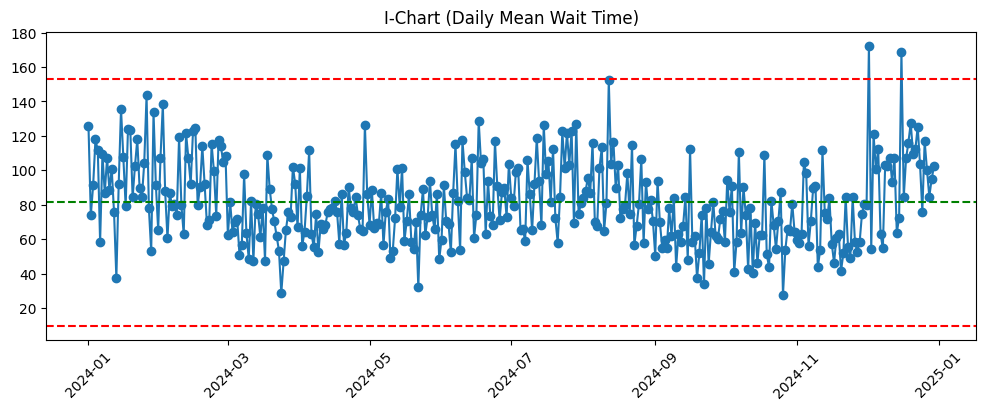

In [ ]:
groups = [g['Total Wait Time (min)'].values for n,g in df.groupby('Time of Day')]
kw_stat, kw_p = stats.kruskal(*groups)
print("Kruskal-Wallis (Time of Day):", kw_stat, kw_p)

daily = df.groupby(df['Visit Date'].dt.date)['Total Wait Time (min)'].mean().reset_index()
mu, sd = daily['Total Wait Time (min)'].mean(), daily['Total Wait Time (min)'].std()
ucl, lcl = mu + 3*sd, mu - 3*sd
plt.figure(figsize=(12,4))
plt.plot(daily['Visit Date'], daily['Total Wait Time (min)'], marker='o')
plt.axhline(mu, color='green', linestyle='--')
plt.axhline(ucl, color='red', linestyle='--'); plt.axhline(lcl, color='red', linestyle='--')
plt.title('I-Chart (Daily Mean Wait Time)'); plt.xticks(rotation=45); plt.show()

###  Kruskal-wallis( ANOVA) p-value < 0.001 → highly significant differences exist between time periods

In [ ]:
import plotly.express as px
from scipy import stats

slope, intercept, r_value, _, _ = stats.linregress(df['Nurse-to-Patient Ratio'], df['Total Wait Time (min)'])
fig = px.scatter(df, x='Nurse-to-Patient Ratio', y='Total Wait Time (min)',
                 color='Total Wait Time (min)', trendline='ols',
                 title=f'ER Wait Time vs Nurse-to-Patient Ratio (R²={r_value**2:.3f})',
                 width=800, height=500, opacity=0.6)
fig.show()

/tmp/ipython-input-2119717782.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



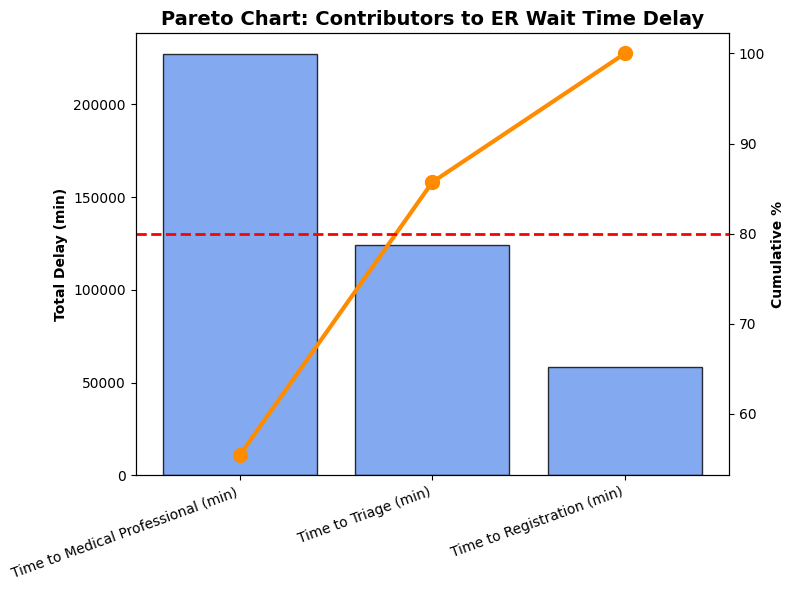

In [ ]:
factors = ['Time to Medical Professional (min)', 'Time to Triage (min)', 'Time to Registration (min)']
contrib = df[factors].sum().sort_values(ascending=False)
pareto = (contrib.cumsum() / contrib.sum() * 100)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.bar(contrib.index, contrib.values, color='cornflowerblue', alpha=0.8, edgecolor='black')
ax1.set_xticklabels(contrib.index, rotation=20, ha='right')
ax2 = ax1.twinx()
ax2.plot(pareto.index, pareto.values, 'o-', color='darkorange', linewidth=3, markersize=10)
ax2.axhline(80, color='red', linestyle='--', linewidth=2)
ax1.set_ylabel('Total Delay (min)', fontweight='bold'); ax2.set_ylabel('Cumulative %', fontweight='bold')
plt.title('Pareto Chart: Contributors to ER Wait Time Delay', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

Pareto proportions (%)
 Time to Medical Professional (min)    55.4
Time to Triage (min)                  30.3
Time to Registration (min)            14.3
dtype: float64


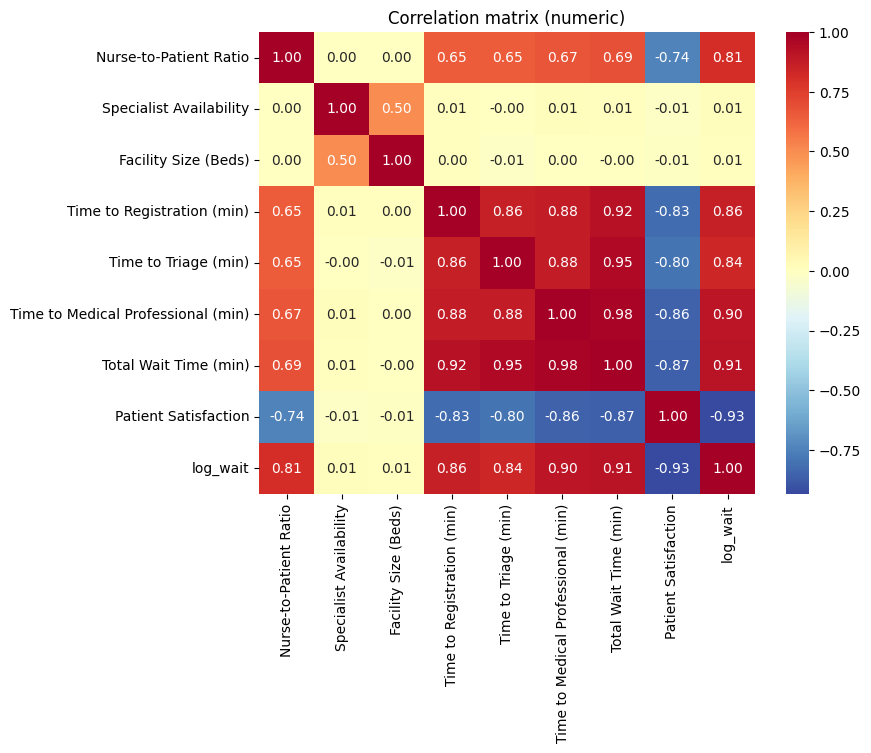

In [ ]:
factors = ['Time to Medical Professional (min)', 'Time to Triage (min)', 'Time to Registration (min)']
vals = df[factors].sum().sort_values(ascending=False)
props = vals / vals.sum() * 100
print("Pareto proportions (%)\n", props.round(1))

num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8,6))
sns.heatmap(num.corr(), annot=True, fmt='.2f', cmap='RdYlBu_r', center=0)
plt.title('Correlation matrix (numeric)')
plt.show()


In [ ]:
grp = df.groupby('Time of Day')['Total Wait Time (min)'].agg(['count','median','mean','std']).sort_values('mean', ascending=False)
print(grp)

               count  median       mean        std
Time of Day                                       
Evening         1725    74.0  99.708406  79.317010
Afternoon       1502    60.0  80.550599  64.690858
Night            530    59.0  74.573585  58.844186
Late Morning     770    55.0  68.100000  53.779632
Early Morning    473    38.0  52.088795  42.291670


In [ ]:
fmea = pd.DataFrame({
    'Process Step': ['Registration', 'Triage', 'Medical Assessment'],
    'Failure Mode': ['Slow check-in / system', 'Queueing / staff shortage', 'Provider unavailable / boarding'],
    'Severity': [8, 9, 9],   # example scores 1-10
    'Occurrence': [6, 7, 5],
    'Detection': [5, 4, 6]
})
fmea['RPN'] = fmea['Severity']*fmea['Occurrence']*fmea['Detection']
print("\nFMEA (example):\n", fmea.sort_values('RPN', ascending=False))


five_whys = [
 "Problem: Long Total Wait Time in Evening",
 "Why1: Staffing low during Evening",
 "Why2: Demand peaks 16:00-20:00 not forecasted",
 "Why3: Scheduling rules fixed, no flex staff",
 "Why4: No automated trigger to add staff",
 "Why5: Lack of data-driven staffing policy"
]
print("\n5-Whys example:\n", "\n".join(five_whys))


FMEA (example):
          Process Step                     Failure Mode  Severity  Occurrence  \
2  Medical Assessment  Provider unavailable / boarding         9           5   
1              Triage        Queueing / staff shortage         9           7   
0        Registration           Slow check-in / system         8           6   

   Detection  RPN  
2          6  270  
1          4  252  
0          5  240  

5-Whys example:
 Problem: Long Total Wait Time in Evening
Why1: Staffing low during Evening
Why2: Demand peaks 16:00-20:00 not forecasted
Why3: Scheduling rules fixed, no flex staff
Why4: No automated trigger to add staff
Why5: Lack of data-driven staffing policy


In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
# ============================================================================
# IMPROVE PHASE - STEP 1: Data Preparation
# ============================================================================

print("="*70)
print("STEP 1: Preparing Data for Machine Learning")
print("="*70)

df_model = df.copy()


df_model = pd.get_dummies(
    df_model,
    columns=['Time of Day', 'Urgency Level', 'Day of Week', 'Region', 'Season'],
    drop_first=True
)


exclude = [
    'Visit ID', 'Patient ID', 'Hospital ID', 'Hospital Name', 'Visit Date',
    'Total Wait Time (min)',  # target variable
    'Patient Outcome', 'Patient Satisfaction', 'log_wait',
    'Time to Registration (min)',
    'Time to Triage (min)',
    'Time to Medical Professional (min)'
]

feat_cols = [c for c in df_model.columns if c not in exclude]

X = df_model[feat_cols].fillna(0)
y = df_model['Total Wait Time (min)'].values

print(f"\n Total features: {len(feat_cols)}")
print(f" Total samples: {len(X)}")
print(f"\nSample features: {feat_cols[:10]}")
print(f"\nTarget variable: Total Wait Time (min)")
print(f"  Mean: {y.mean():.1f} min")
print(f"  Median: {np.median(y):.1f} min")
print(f"  Std: {y.std():.1f} min")

STEP 1: Preparing Data for Machine Learning

✓ Total features: 20
✓ Total samples: 5000

Sample features: ['Nurse-to-Patient Ratio', 'Specialist Availability', 'Facility Size (Beds)', 'Time of Day_Early Morning', 'Time of Day_Evening', 'Time of Day_Late Morning', 'Time of Day_Night', 'Urgency Level_High', 'Urgency Level_Low', 'Urgency Level_Medium']

Target variable: Total Wait Time (min)
  Mean: 81.9 min
  Median: 60.0 min
  Std: 68.1 min


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

print("="*70)
print("STEP 2: Training XGBoost Model")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✓ Training samples: {len(X_train)}")
print(f"✓ Testing samples: {len(X_test)}")


model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=6,
    n_estimators=200,
    random_state=42,
    verbosity=0
)


print("\nTraining model...)")
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred_baseline = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred_baseline))
r2 = r2_score(y_test, pred_baseline)
mae = mean_absolute_error(y_test, pred_baseline)

print("\n" + "="*70)
print("MODEL PERFORMANCE")
print("="*70)
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} minutes")
print(f"MAE (Mean Absolute Error):      {mae:.2f} minutes")
print(f"R² (Explained Variance):        {r2:.4f} ({r2*100:.1f}%)")
print(f"\nInterpretation:")
print(f" On average, predictions are off by ±{mae:.1f} minutes")
print(f" Model explains {r2*100:.1f}% of variance in wait times")
print(f" Baseline mean wait time: {y_test.mean():.1f} minutes")
print("="*70)

STEP 2: Training XGBoost Model

✓ Training samples: 4000
✓ Testing samples: 1000

Training model... (this may take 10-20 seconds)

MODEL PERFORMANCE
RMSE (Root Mean Squared Error): 17.31 minutes
MAE (Mean Absolute Error):      11.78 minutes
R² (Explained Variance):        0.9356 (93.6%)

Interpretation:
 On average, predictions are off by ±11.8 minutes
 Model explains 93.6% of variance in wait times
 Baseline mean wait time: 82.1 minutes


In [ ]:
# ============================================================================
# GridSearchCV - Hyperparameter Tuning
# ============================================================================

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb



param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42, verbosity=0),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\n Tuning hyperparameters...)")
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("\n" + "="*70)
print("BEST MODEL RESULTS")
print("="*70)
print(f"Best parameters: {grid.best_params_}")
pred_tuned = best_model.predict(X_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test, pred_tuned))

print(f"\nBest model RMSE: {rmse_tuned:.2f} minutes")
print(f"Best model R²: {r2_score(y_test, pred_tuned):.4f}")

print("\n✓ best_model is ready!")
print("="*70)


GridSearchCV: Hyperparameter Tuning

⏳ Tuning hyperparameters... (this may take 2-3 minutes)
Fitting 3 folds for each of 54 candidates, totalling 162 fits

BEST MODEL RESULTS
Best parameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

Best model RMSE: 17.08 minutes
Best model R²: 0.9373

✓ best_model is ready!


In [ ]:
# Improve Phase - STEP 3: Identify Evening Shift Patients for What-If Analysis

print("STEP 3: Filtering Evening Shift Patients")

model = best_model

evening_mask = X_test['Time of Day_Evening'] == 1
X_evening = X_test[evening_mask].copy()
y_evening = y_test[evening_mask]

pred_evening_baseline = model.predict(X_evening)

print(f"\n Total test samples: {len(X_test)}")
print(f"Evening shift samples: {len(X_evening)} ({len(X_evening)/len(X_test)*100:.1f}%)")

print("\n" + "="*70)
print("EVENING SHIFT BASELINE (Current State)")
print("="*70)
print(f"Actual wait times:")
print(f"  Mean:   {y_evening.mean():.1f} min")
print(f"  Median: {np.median(y_evening):.1f} min")
print(f"  Std:    {y_evening.std():.1f} min")
print(f"  Min:    {y_evening.min():.1f} min")
print(f"  Max:    {y_evening.max():.1f} min")

print(f"\nModel predictions (baseline):")
print(f"  Mean:   {pred_evening_baseline.mean():.1f} min")
print(f"  RMSE:   {np.sqrt(mean_squared_error(y_evening, pred_evening_baseline)):.2f} min")

print("\n Ready for intervention simulation!")
print("="*70)

STEP 3: Filtering Evening Shift Patients

✓ Total test samples: 1000
✓ Evening shift samples: 341 (34.1%)

EVENING SHIFT BASELINE (Current State)
Actual wait times:
  Mean:   99.0 min
  Median: 70.0 min
  Std:    80.1 min
  Min:    8.0 min
  Max:    442.0 min

Model predictions (baseline):
  Mean:   97.7 min
  RMSE:   20.68 min

✓ Ready for intervention simulation!


In [ ]:
# IMPROVE PHASE - STEP 4: What-If Intervention Simulation
print("="*70)
print("STEP 4: WHAT-IF SIMULATION - Adding Nurses During Evening Shift")
print("="*70)


print("\n[Scenario 1] Add 2 Nurses...")
X_scenario1 = X_evening.copy()
X_scenario1['Nurse-to-Patient Ratio'] = X_scenario1['Nurse-to-Patient Ratio'] - 0.05

pred_scenario1 = model.predict(X_scenario1)
reduction1 = y_evening.mean() - pred_scenario1.mean()
pct1 = (reduction1 / y_evening.mean()) * 100

print(f" Predicted mean wait: {pred_scenario1.mean():.1f} min")
print(f" Reduction: {reduction1:.1f} min ({pct1:.1f}%)")

# Scenario 2
print("\n[Scenario 2] Add 4 Nurses...")
X_scenario2 = X_evening.copy()
X_scenario2['Nurse-to-Patient Ratio'] = X_scenario2['Nurse-to-Patient Ratio'] - 0.10

pred_scenario2 = model.predict(X_scenario2)
reduction2 = y_evening.mean() - pred_scenario2.mean()
pct2 = (reduction2 / y_evening.mean()) * 100

print(f"  Predicted mean wait: {pred_scenario2.mean():.1f} min")
print(f"  Reduction: {reduction2:.1f} min ({pct2:.1f}%)")

# Add 6 nurses + increase specialist availability by 20%
print("\n[Scenario 3] Add 6 Nurses + 20% More Specialists...")
X_scenario3 = X_evening.copy()
X_scenario3['Nurse-to-Patient Ratio'] = X_scenario3['Nurse-to-Patient Ratio'] - 0.15
X_scenario3['Specialist Availability'] = X_scenario3['Specialist Availability'] * 1.2

pred_scenario3 = model.predict(X_scenario3)
reduction3 = y_evening.mean() - pred_scenario3.mean()
pct3 = (reduction3 / y_evening.mean()) * 100

print(f" Predicted mean wait: {pred_scenario3.mean():.1f} min")
print(f" Reduction: {reduction3:.1f} min ({pct3:.1f}%)")

print("\n" + "="*70)
print("SIMULATION RESULTS SUMMARY")
print("="*70)

results = pd.DataFrame({
    'Scenario': [
        'Baseline (Current)',
        'Add 2 Nurses',
        'Add 4 Nurses',
        'Add 6 Nurses + 20% Specialists'
    ],
    'Mean Wait (min)': [
        y_evening.mean(),
        pred_scenario1.mean(),
        pred_scenario2.mean(),
        pred_scenario3.mean()
    ],
    'Reduction (min)': [
        0,
        reduction1,
        reduction2,
        reduction3
    ],
    'Reduction (%)': [
        0,
        pct1,
        pct2,
        pct3
    ]
})

print(results.to_string(index=False))
print("="*70)

STEP 4: WHAT-IF SIMULATION - Adding Nurses During Evening Shift

[Scenario 1] Add 2 Nurses...
  Predicted mean wait: 89.9 min
  Reduction: 9.1 min (9.2%)

[Scenario 2] Add 4 Nurses...
  Predicted mean wait: 89.9 min
  Reduction: 9.1 min (9.2%)

[Scenario 3] Add 6 Nurses + 20% More Specialists...
  Predicted mean wait: 89.8 min
  Reduction: 9.2 min (9.3%)

SIMULATION RESULTS SUMMARY
                      Scenario  Mean Wait (min)  Reduction (min)  Reduction (%)
            Baseline (Current)        99.002933         0.000000       0.000000
                  Add 2 Nurses        89.869064         9.133868       9.225856
                  Add 4 Nurses        89.869064         9.133868       9.225856
Add 6 Nurses + 20% Specialists        89.840637         9.162295       9.254570


STEP 5: Creating Visualizations


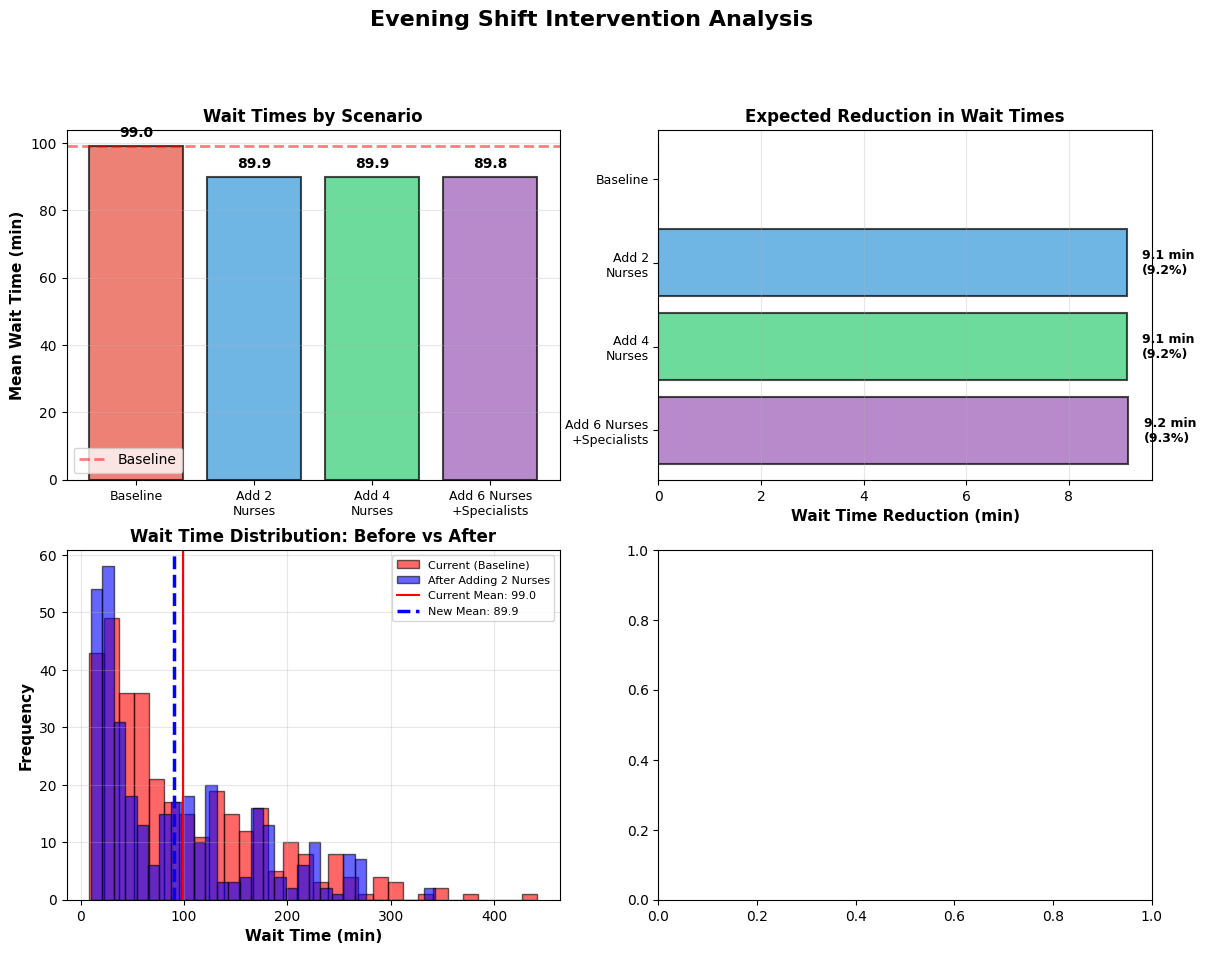

In [ ]:
# ============================================================================
# IMPROVE PHASE - STEP 5: Visualization
# ============================================================================

print("="*70)
print("STEP 5: Creating Visualizations")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Evening Shift Intervention Analysis', fontsize=16, fontweight='bold', y=1.00)

ax1 = axes[0, 0]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
bars = ax1.bar(range(4), results['Mean Wait (min)'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(4))
ax1.set_xticklabels(['Baseline', 'Add 2\nNurses', 'Add 4\nNurses', 'Add 6 Nurses\n+Specialists'], fontsize=9)
ax1.set_ylabel('Mean Wait Time (min)', fontweight='bold', fontsize=11)
ax1.set_title('Wait Times by Scenario', fontweight='bold', fontsize=12)
ax1.axhline(y_evening.mean(), color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2 = axes[0, 1]
reductions = results['Reduction (min)'].values
bars2 = ax2.barh(range(4), reductions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(4))
ax2.set_yticklabels(['Baseline', 'Add 2\nNurses', 'Add 4\nNurses', 'Add 6 Nurses\n+Specialists'], fontsize=9)
ax2.set_xlabel('Wait Time Reduction (min)', fontweight='bold', fontsize=11)
ax2.set_title('Expected Reduction in Wait Times', fontweight='bold', fontsize=12)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

for i, v in enumerate(reductions):
    if v > 0:
        ax2.text(v + 0.3, i, f'{v:.1f} min\n({results["Reduction (%)"].iloc[i]:.1f}%)',
                va='center', fontweight='bold', fontsize=9)

ax3 = axes[1, 0]
ax3.hist(y_evening, bins=30, alpha=0.6, label='Current (Baseline)', color='red', edgecolor='black')
ax3.hist(pred_scenario1, bins=30, alpha=0.6, label='After Adding 2 Nurses', color='blue', edgecolor='black')
ax3.axvline(y_evening.mean(), color='red',  label=f'Current Mean: {y_evening.mean():.1f}')
ax3.axvline(pred_scenario1.mean(), color='blue', linestyle='--', linewidth=2.5, label=f'New Mean: {pred_scenario1.mean():.1f}')
ax3.set_xlabel('Wait Time (min)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax3.set_title('Wait Time Distribution: Before vs After', fontweight='bold', fontsize=12)
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3)


In [ ]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(pred_scenario1, y_evening, alternative='less')
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


T-statistic: -1.528, P-value: 0.064


In [ ]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(pred_scenario1, y_evening, alternative='less')
print(f"U-statistic: {u_stat:.3f}, P-value: {p_value:.3f}")


U-statistic: 52945.000, P-value: 0.022


In [ ]:
import numpy as np
effect_size = (np.mean(y_evening) - np.mean(pred_scenario1)) / np.std(y_evening)
print(f"Cohen's d effect size: {effect_size:.2f}")


Cohen's d effect size: 0.11
